# Model trainer
Definición y entrenamiento del modelo.

Referencias: 
*  https://keras.io/examples/vision/super_resolution_sub_pixel/
*  https://pyimagesearch.com/2021/09/27/pixel-shuffle-super-resolution-with-tensorflow-keras-and-deep-learning/

Importamos las librerías necesarias.

In [1]:
import os
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Input, Add, Conv2D
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.callbacks import EarlyStopping


Bloque de configuración:

In [2]:
# root path
ROOT_PATH = 'C:\\_pfm'

# specify paths to the different splits of the dataset
TRAIN_SET = os.path.join(ROOT_PATH, 'img', 'train')
VAL_SET = os.path.join(ROOT_PATH, 'img', 'val')
SAVED_MODEL = os.path.join(ROOT_PATH, 'model')

# specify the initial size of the images and downsampling factor
ORIG_SIZE = (300, 300)
DOWN_FACTOR = 3

# specify number of RDB blocks, batch size, number of epochs, and
# initial learning rate to train our model
RDB_LAYERS = 3
BATCH_SIZE = 8
EPOCHS = 1 #100
LR = 1e-3
PATIENCE = 10


Funciones varias necesarias para construir y entrenar el modelo.

In [3]:
# Función que toma la ruta de una imagen y devuelve el parde entrenamiento muestra-objetivo.

def process_input(imagePath, downFactor=DOWN_FACTOR):
    # determine size of the downsampled images
    resizeShape = ORIG_SIZE[0] // downFactor
    
    # load the original image from disk, decode it as a JPEG image,
    # scale its pixel values to [0, 1] range, and resize the image
    origImage = tf.io.read_file(imagePath)
    origImage = tf.image.decode_jpeg(origImage, 3)
    origImage = tf.image.convert_image_dtype(origImage, tf.float32)
    origImage = tf.image.resize(origImage, ORIG_SIZE, method="area")

    # convert the color space from RGB to YUV and only keep the Y
    # channel (which is our target variable)
    origImageYUV = tf.image.rgb_to_yuv(origImage)
    (target, _, _) = tf.split(origImageYUV, 3, axis=-1)
    
    # resize the target to a lower resolution
    downImage = tf.image.resize(target, [resizeShape, resizeShape], method="area")
    
    # clip the values of the input and target to [0, 1] range
    target = tf.clip_by_value(target, 0.0, 1.0)
    downImage = tf.clip_by_value(downImage, 0.0, 1.0)
    
    # return a tuple of the downsampled image and original image
    # Nota: el entrenamienmto se realiza con tamaños de imagen fijados (100x100 y 300x300) y sobre el canal Y (luminosidad).
    return (downImage, target)


In [4]:
# Función que genera los bloques RDB (Residual Dense Blocks) del modelo

def rdb_block(inputs, numLayers):
    # determine the number of channels present in the current input
    # and initialize a list with the current inputs for concatenation
    channels = inputs.get_shape()[-1]
    storedOutputs = [inputs]
    
    # iterate through the number of residual dense layers
    for _ in range(numLayers):
        # concatenate the previous outputs and pass it through a
        # CONV layer, and append the output to the ongoing concatenation
        localConcat = tf.concat(storedOutputs, axis=-1)
        out = Conv2D(filters=channels, 
            kernel_size=3, 
            padding="same",
            activation="relu",
            kernel_initializer="Orthogonal")(localConcat)
        storedOutputs.append(out)
        
    # concatenate all the outputs, pass it through a pointwise
    # convolutional layer, and add the outputs to initial inputs
    finalConcat = tf.concat(storedOutputs, axis=-1)
    finalOut = Conv2D(filters=inputs.get_shape()[-1], 
        kernel_size=1,
        padding="same", 
        activation="relu",
        kernel_initializer="Orthogonal")(finalConcat)
    finalOut = Add()([finalOut, inputs])
    
    # return the final output
    return finalOut


In [5]:
# Función que construye el modelo

def get_subpixel_net(downsampleFactor=DOWN_FACTOR, channels=1, rdbLayers=RDB_LAYERS):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    
    # initialize an input layer
    inputs = Input((None, None, 1))
    
    # pass the inputs through a CONV => CONV block
    x = Conv2D(64, 5, **conv_args)(inputs)
    x = Conv2D(64, 3, **conv_args)(x)
    
    # pass the outputs through an RDB => CONV => RDB block
    x = rdb_block(x, numLayers=rdbLayers)
    x = Conv2D(32, 3, **conv_args)(x)
    x = rdb_block(x, numLayers=rdbLayers)
    
    # pass the inputs through a final CONV layer such that the
    # channels of the outputs can be spatially organized into
    # the output resolution
    x = Conv2D(channels * (downsampleFactor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, downsampleFactor)

    # construct the final model and return it
    model = Model(inputs, outputs)
    
    return model


In [6]:
# Función que calcula el PSNR (Peak Signal to Noise Ratio). Usaremos el PSNR como métrica de nuestro modelo

def psnr(orig, pred):
    # cast the target images to integer
    orig = orig * 255.0
    orig = tf.cast(orig, tf.uint8)
    orig = tf.clip_by_value(orig, 0, 255)

    # cast the predicted images to integer
    pred = pred * 255.0
    pred = tf.cast(pred, tf.uint8)
    pred = tf.clip_by_value(pred, 0, 255)
    
    # return the psnr
    return tf.image.psnr(orig, pred, max_val=255)


In [7]:
# Función que muestra la evolución de la función de pérdida y de la metrica durante el entrenamiento

def show_loss_psnr_evolution(hist):

    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.set_title("Training/validation Loss (MSE)")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(hist['loss'], label='Train Error')
    ax1.plot(hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_title("Training/validation PSNR")
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('PSNR')
    ax2.plot(hist['psnr'], label='Train PSNR')
    ax2.plot(hist['val_psnr'], label = 'Val PSNR')
    ax2.grid()
    ax2.legend()

    plt.show()
    

In [8]:
# Creación de los datasets

# define autotune flag for performance optimization
AUTO = tf.data.experimental.AUTOTUNE

# load the image paths from disk and initialize TensorFlow Dataset objects
print("[INFO] loading images from disk...")
trainPaths = list(paths.list_images(TRAIN_SET))
valPaths = list(paths.list_images(VAL_SET))
trainDS = tf.data.Dataset.from_tensor_slices(trainPaths)
valDS = tf.data.Dataset.from_tensor_slices(valPaths)

# prepare data loaders
print("[INFO] preparing data loaders...")
trainDS = trainDS.map(process_input, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
valDS = valDS.map(process_input, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)


[INFO] loading images from disk...
[INFO] preparing data loaders...


### Entrenamiento

In [9]:
print("[INFO] initializing and training model...")
model = get_subpixel_net()
##model.summary()

[INFO] initializing and training model...


In [10]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

callbacks = [early_stopping_callback]

loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=LR)

In [11]:
# initialize, compile, and train the model
# metrica PSNR: the goal of our model will be to maximize the Peak Signal to Noise Ratio
# We use the 'adam' optimizer and choose 'mse' (mean squared error) as our loss function

model.compile(optimizer=optimizer, loss=loss_fn, metrics=psnr)

H = model.fit(trainDS, validation_data=valDS, epochs=EPOCHS, callbacks=callbacks, verbose=1)


100/100 [==============================] - 175s 2s/step - loss: 0.0166 - psnr: 22.4396 - val_loss: 0.0013 - val_psnr: 28.6528


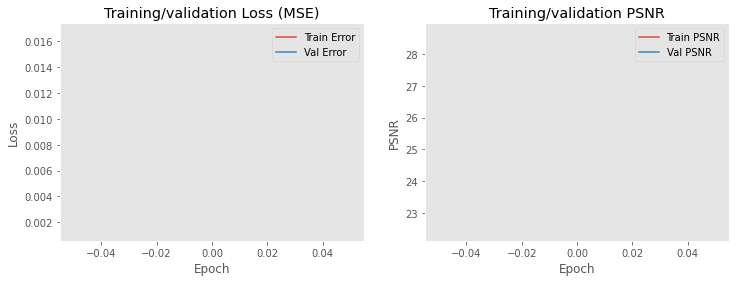

In [12]:
# Evolución el entrenamiento
show_loss_psnr_evolution(H.history)


## Guardar modelo
Guardamos el modelo para poder usarlo directamente en nuesta aplicación.

In [13]:
# save the trained model
print("[INFO] saving model...")
save_model(model, SAVED_MODEL)

[INFO] saving model...
INFO:tensorflow:Assets written to: C:\_pfm\model\assets
